In [67]:
# Python imports
import os

# PyTorch imports
import torch
import torchvision

# Third-party imports
import matplotlib.pyplot as plt

# Own imports
import utils

# 0. Constants

In [68]:
BATCH_SIZE = 10
LEARNING_RATE = 0.001
EPOCHS = 30
WIDTH, HEIGHT = 28, 28
SAVED_FILENAME = 'MNIST-0'

# 1. Dataset

In [69]:
dataset_training = torchvision.datasets.MNIST('./data', download=True, train=True, transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST('./data', download=True, train=False, transform=torchvision.transforms.ToTensor())

In [70]:
dataloader_training = torch.utils.data.DataLoader(dataset_training, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

## 1.1. Dataset Properties

### 1.1.1. Length of Datasets

In [71]:
print(f'Length of training dataset: {len(dataset_training)}')
print(f'Length of test dataset: {len(dataset_test)}')

Length of training dataset: 60000
Length of test dataset: 10000


### 1.1.2. Value Range

In [72]:
image, _ = dataset_training[0]
print(f'Min value of images is {image.min()}')
print(f'Max value of images is {image.max()}')

Min value of images is 0.0
Max value of images is 1.0


### 1.1.3. Sample Plots

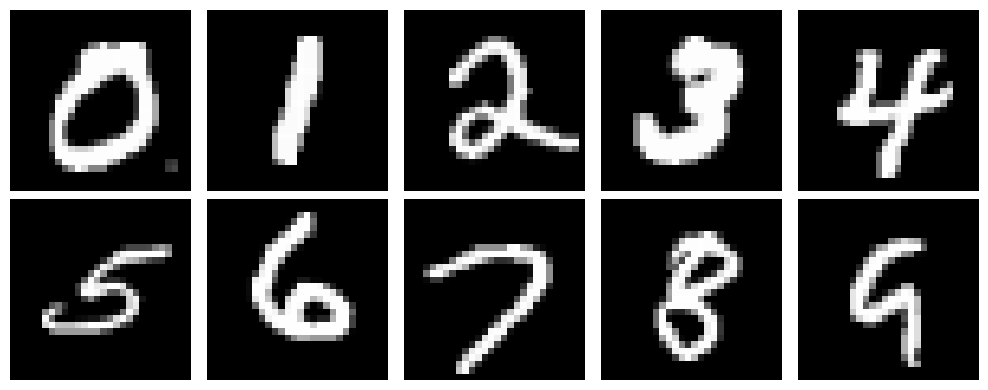

In [73]:
# Sample 10 images with labels 0 to 9.
samples = utils.sample_MNIST_with_all_labels(dataset_training)

# Plot the images.
rows, cols = 2, 5
plt.figure(figsize=(10, 4))
for i in range(rows * cols):
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(samples[i].squeeze(), cmap=plt.cm.gray)
plt.tight_layout()

# 2. Model

In [74]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(WIDTH*HEIGHT, 10),
    torch.nn.Softmax(dim=1)
)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
  (2): Softmax(dim=1)
)


## 2.1. Statistics of the Model

In [75]:
num_parameters_total = 0
for params in model.parameters():
    num_parameters = 1
    size = params.size()
    for dim_size in size:
        num_parameters *= dim_size
    num_parameters_total += num_parameters

print(f'Total number of parameters: {num_parameters_total}')

Total number of parameters: 7850


# 2.2. Use the model before training

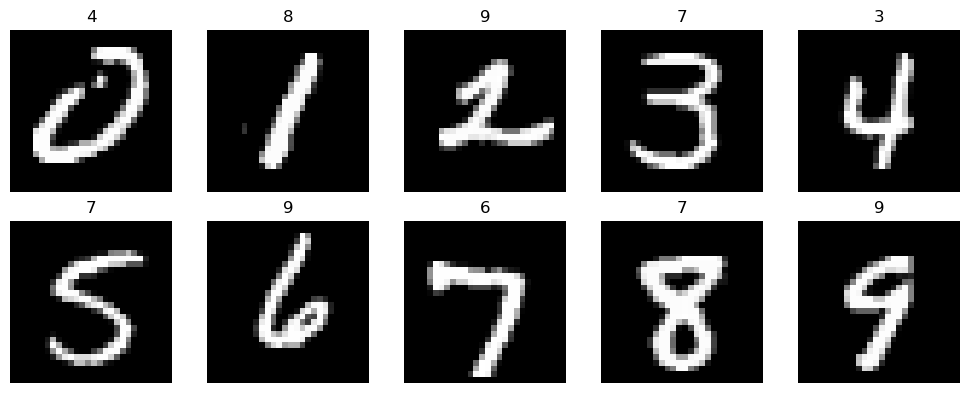

In [76]:
# Sample 10 images with labels 0 to 9 from the test dataset.
samples = utils.sample_MNIST_with_all_labels(dataset_test)

preds = {}
for label, image in samples.items():
    pred = model(image)
    preds[label] = pred.argmax(dim=1)[0].item()

# Plot the images with labels.
rows, cols = 2, 5
plt.figure(figsize=(10, 4))
for i in range(rows * cols):
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(samples[i].squeeze(), cmap=plt.cm.gray)
    plt.title(preds[i])
plt.tight_layout()

# 3. Training

## 3.1. Helper Functions

In [77]:
def calculateStatistics(dataloader, model, loss_fn):
    with torch.no_grad():
        num_batches = len(dataloader)
        num_samples = len(dataloader.dataset)
        loss, correct = 0, 0

        for images, labels in dataloader:
            # Make predictions.
            preds = model(images)

            # Calculate the loss.
            loss += loss_fn(preds, labels)

            # Calculate the number of correctnesses.
            correct += (preds.argmax(dim=1) == labels).type(dtype=torch.float32).sum()

        # Calculate the mean loss and correct.
        loss /= num_batches
        correct /= num_samples

    return loss, correct

## 3.2. Training

In [78]:
def load(model):
    # Retrieve saved data.
    data = torch.load(f'saved/{SAVED_FILENAME}.pt')

    # Resume model from saved data.
    state_dict = data['state_dict']
    model.load_state_dict(state_dict)

    # Return losses and accuracies for training and testing.
    return data['losses'], data['corrects'], data['losses_test'], data['corrects_test']

In [79]:
def save(model, losses, corrects, losses_test, corrects_test):
    # Create folder 'saved' if it does not exist.
    if not os.path.exists('saved'):
        os.makedirs('saved')

    # Construct the struct of data to save.
    data = {
        'state_dict': model.state_dict(),
        'losses': losses,
        'corrects': corrects,
        'losses_test': losses_test,
        'corrects_test': corrects_test,
    }

    # Save data to the file.
    torch.save(data, f'saved/{SAVED_FILENAME}.pt')

In [80]:
def train(model, epochs):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), LEARNING_RATE)

    # Define losses and corrects for training and test.
    losses, corrects = [], []
    losses_test, corrects_test = [], []

    # Calculate losses and corrects before training.
    loss, correct = calculateStatistics(dataloader_training, model, loss_fn)
    losses.append(loss)
    corrects.append(correct)
    loss_test, correct_test = calculateStatistics(dataloader_test, model, loss_fn)
    losses_test.append(loss)
    corrects_test.append(correct_test)

    # Print statistics.
    print(f'Training error: loss: {loss:>7f}, accuracy: {correct*100:>0.1f}%')
    print(f'Test error: loss: {loss_test:>7f}, accuracy: {correct_test*100:>0.1f}%')

    # Run epochs.
    for epoch in range(epochs):

        # Run one epoch for training.
        num_batches = len(dataloader_training)
        num_samples = len(dataloader_training.dataset)
        loss_epoch, correct_epoch = 0, 0
        for batch, [images, labels] in enumerate(dataloader_training):
            # Make predictions.
            pred = model(images)

            # Calculate the loss.
            loss = loss_fn(pred, labels)
            loss_epoch += loss.item()

            # Calculate the number of correctness.
            correct_epoch += (pred.argmax(dim=1) == labels).type(dtype=torch.float32).sum().item()

            # Back propagation.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (batch + 1) % 1000 == 0:
                loss, size_current, size_total = loss.item(), (batch+1)*BATCH_SIZE, len(dataloader_training.dataset)
                print(f'loss: {loss:>7f} [{size_current:>5d} / {size_total:>5d}]')
            
        # Calculate the mean loss across all batches.
        loss_epoch /= num_batches
        losses.append(loss_epoch)

        # Calculate the mean number of correctness across all batches.
        correct_epoch /= num_samples
        corrects.append(correct_epoch)

        # Print statistics of the training part of the epoch.
        print(f'Training error: loss: {loss_epoch:>7f}, accuracy: {correct_epoch*100:>0.1f}%')

        # Calculate loss and correct for test.
        loss_test, correct_test = calculateStatistics(dataloader_test, model, loss_fn)
        losses_test.append(loss_test)
        corrects_test.append(correct_test)

        # Print statistics of the test part of the epoch.
        print(f'Test error: loss: {loss_test:>7f}, accuracy: {correct_test*100:>0.1f}%')

    # Return losses and accuracies for training and testing.
    return losses, corrects, losses_test, corrects_test


In [81]:
if os.path.exists(f'saved/{SAVED_FILENAME}.pt'):
    losses, corrects, losses_test, corrects_test = load(model)
else:
    losses, corrects, losses_test, corrects_test = train(model, EPOCHS)
    save(model, losses, corrects, losses_test, corrects_test)

## 3.3. Visualization of the training process

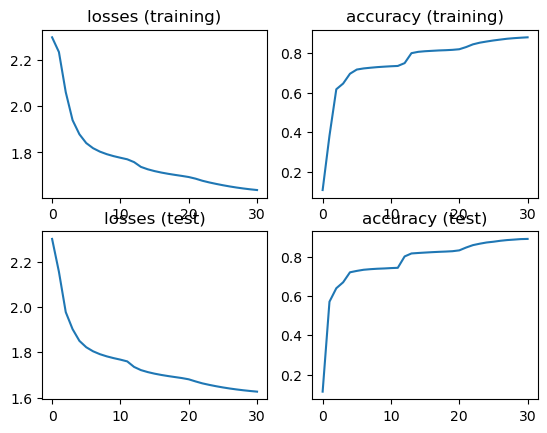

In [82]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2,2)

ax11.plot(losses)
ax11.set_title('losses (training)')
ax12.plot(corrects)
ax12.set_title('accuracy (training)')
ax21.plot(losses_test)
ax21.set_title('losses (test)')
ax22.plot(corrects_test)
ax22.set_title('accuracy (test)')

plt.show()

# 4. Use

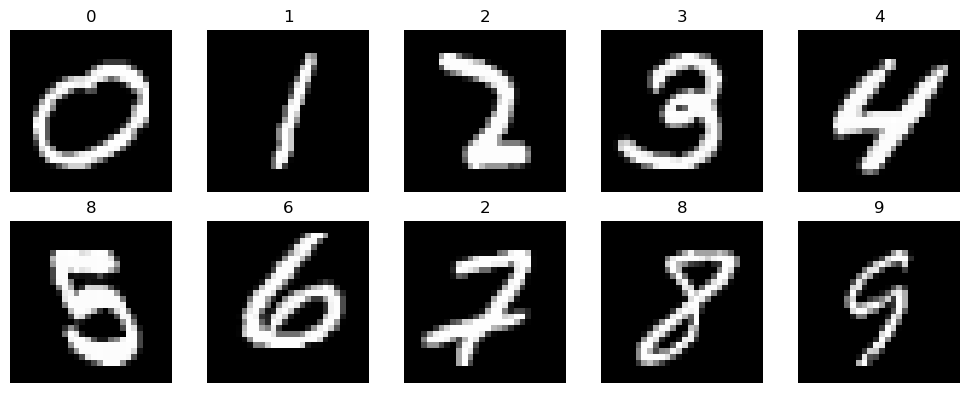

In [83]:
# Sample 10 images with labels 0 to 9 from the test dataset.
samples = utils.sample_MNIST_with_all_labels(dataset_test)

preds = {}
for label, image in samples.items():
    pred = model(image)
    preds[label] = pred.argmax(dim=1)[0].item()

# Plot the images with labels.
rows, cols = 2, 5
plt.figure(figsize=(10, 4))
for i in range(rows * cols):
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(samples[i].squeeze(), cmap=plt.cm.gray)
    plt.title(preds[i])
plt.tight_layout()